In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from scipy.ndimage import gaussian_filter, geometric_transform

from src.data.datasets import InMemorySurfaceVolumeDataset, build_z_shift_scale_maps
from src.data.datamodules import read_data
from src.utils.utils import (
    normalize_volume, 
    get_z_volume_mean_per_z, 
    fit_x_shift_scale, 
    build_nan_or_outliers_mask, 
    interpolate_masked_pixels, 
    calculate_statistics
)

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


# Centering the papyrus

In [3]:
fragment_pathes = [
    '/workspace/data/fragments_downscaled_2/train/1',
    '/workspace/data/fragments_downscaled_2/train/2',
    '/workspace/data/fragments_downscaled_2/train/3',
]
volumes, scroll_masks, ir_images, ink_masks, subtracts, divides = \
    read_data(fragment_pathes, center_crop_z=None)

### Rough (full fragment)

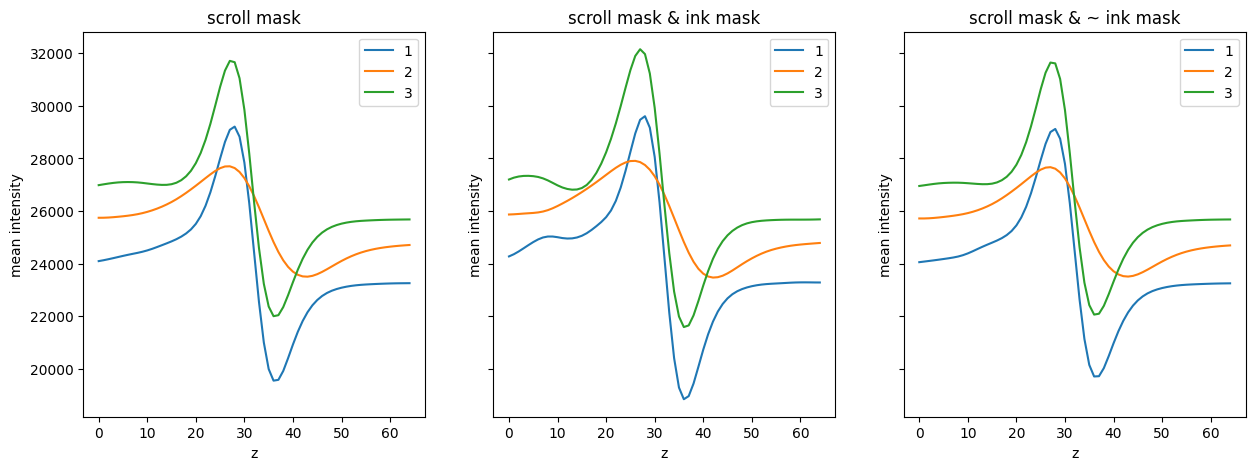

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i, path in enumerate(fragment_pathes):
    name = path.split('/')[-1]
    H, W, D = volumes[i].shape
    scroll_mask_flattened_xy = (scroll_masks[i] > 0).flatten()
    ink_mask_flattened_xy = (ink_masks[i] > 0).flatten()
    volume_flattened_xy = volumes[i].reshape(H * W, D)

    volume_flattened_xy_scroll = volume_flattened_xy[scroll_mask_flattened_xy]
    ax = axes[0]
    ax.plot(volume_flattened_xy_scroll.mean(axis=0), label=f'{name}')

    volume_flattened_xy_scroll_pos = volume_flattened_xy[scroll_mask_flattened_xy & ink_mask_flattened_xy]
    ax = axes[1]
    ax.plot(volume_flattened_xy_scroll_pos.mean(axis=0), label=f'{name}')

    volume_flattened_xy_scroll_neg = volume_flattened_xy[scroll_mask_flattened_xy & (~ink_mask_flattened_xy)]
    ax = axes[2]
    ax.plot(volume_flattened_xy_scroll_neg.mean(axis=0), label=f'{name}')

axes[0].set_title('scroll mask')
axes[0].set_xlabel('z')
axes[0].set_ylabel('mean intensity')
axes[0].legend()

axes[1].set_title('scroll mask & ink mask')
axes[1].set_xlabel('z')
axes[1].set_ylabel('mean intensity')
axes[1].legend()

axes[2].set_title('scroll mask & ~ ink mask')
axes[2].set_xlabel('z')
axes[2].set_ylabel('mean intensity')
axes[2].legend()

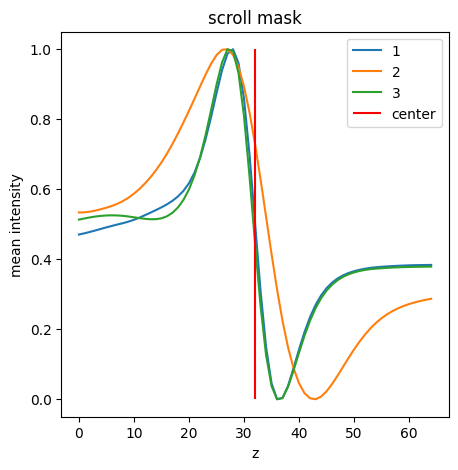

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, path in enumerate(fragment_pathes):
    name = path.split('/')[-1]
    H, W, D = volumes[i].shape
    scroll_mask_flattened_xy = (scroll_masks[i] > 0).flatten()
    volume_flattened_xy = volumes[i].reshape(H * W, D)

    volume_flattened_xy_scroll = volume_flattened_xy[scroll_mask_flattened_xy].astype(float)
    volume_mean_per_z = volume_flattened_xy_scroll.mean(0)
    volume_flattened_xy_scroll = (
        volume_flattened_xy_scroll - volume_mean_per_z.min()
    ) / (volume_mean_per_z.max() - volume_mean_per_z.min())
    ax.plot(volume_flattened_xy_scroll.mean(0), label=f'{name}')

ax.vlines(32, 0, 1, color='r', label='center')

ax.set_title('scroll mask')
ax.set_xlabel('z')
ax.set_ylabel('mean intensity')
ax.legend()

name=1: min=19548.20949465677, max=29210.2702697769, z_scale=1, z_shift=0
name=2: min=23502.33653187867, max=27700.72170622774, z_scale=0.55, z_shift=13
name=3: min=22000.041270801805, max=31710.525060789045, z_scale=1, z_shift=0


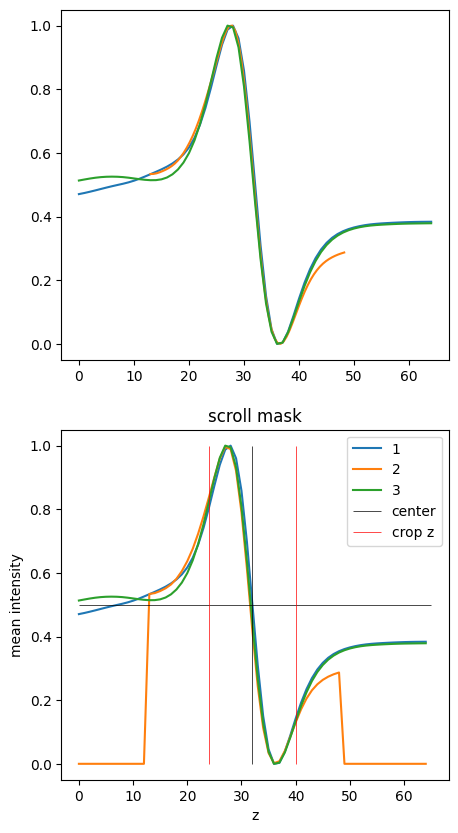

In [6]:
import cv2


center_z = 32

fig, axes = plt.subplots(2, 1, figsize=(5, 10))
for i, path in enumerate(fragment_pathes):
    name = path.split('/')[-1]
    H, W, D = volumes[i].shape
    scroll_mask_flattened_xy = (scroll_masks[i] > 0).flatten()
    volume_flattened_xy = volumes[i].reshape(H * W, D)

    volume_flattened_xy_scroll = volume_flattened_xy[scroll_mask_flattened_xy].astype(float)
    volume_mean_per_z = volume_flattened_xy_scroll.mean(0)

    volume_mean_per_z_min = volume_mean_per_z.min()
    volume_mean_per_z_max = volume_mean_per_z.max()
    volume_flattened_xy_scroll = (
        volume_flattened_xy_scroll - volume_mean_per_z_min
    ) / (volume_mean_per_z_max - volume_mean_per_z_min)

    z = np.arange(D)
    volume_mean_per_z = volume_flattened_xy_scroll.mean(0)

    z_scale, z_shift = 1, 0
    if name == '2':
        z_scale = 0.55
        z_shift = 13

    z = z * z_scale + z_shift
    ax = axes[0]
    ax.plot(z, volume_mean_per_z, label=f'{name}')

    volume_flattened_xy_scroll = cv2.resize(
        volume_flattened_xy_scroll, 
        (0, 0),
        fx=z_scale, 
        fy=1,
        interpolation=cv2.INTER_LINEAR,
    )
    volume_flattened_xy_scroll = cv2.copyMakeBorder(
        volume_flattened_xy_scroll,
        top=0,
        bottom=0,
        left=z_shift,
        right=0,
        borderType=cv2.BORDER_CONSTANT, 
        value=0,
    )
    volume_flattened_xy_scroll = cv2.copyMakeBorder(
        volume_flattened_xy_scroll,
        top=0,
        bottom=0,
        left=0,
        right=D - volume_flattened_xy_scroll.shape[1],
        borderType=cv2.BORDER_CONSTANT, 
        value=0,
    )

    z = np.arange(D)
    volume_mean_per_z = volume_flattened_xy_scroll.mean(0)
    ax = axes[1]
    ax.plot(z, volume_mean_per_z, label=f'{name}')
    
    print(
        f'name={name}: '
        f'min={volume_mean_per_z_min}, '
        f'max={volume_mean_per_z_max}, '
        f'z_scale={z_scale}, '
        f'z_shift={z_shift}'
    )

ax.vlines(center_z, 0, 1, color='k', linewidth=0.5, label='center')
ax.hlines(0.5, 0, 65, color='k', linewidth=0.5)

crop_z_span = 8
ax.vlines([center_z + crop_z_span, center_z - crop_z_span], 0, 1, color='r', linewidth=0.5, label='crop z')

ax.set_title('scroll mask')
ax.set_xlabel('z')
ax.set_ylabel('mean intensity')
ax.legend()

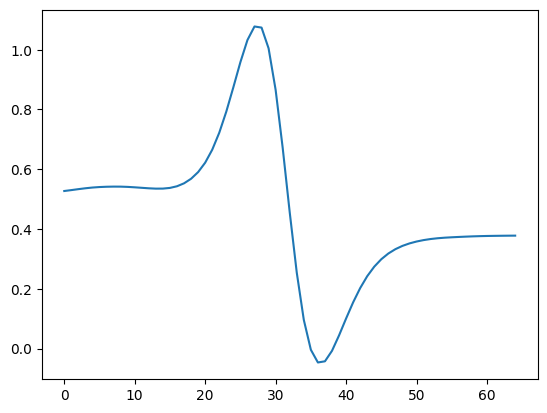

In [7]:
volume = normalize_volume(volumes[2], scroll_masks[2], mode='volume_mean_per_z', normalize='quantile')
z_target, volume_mean_per_z_target = get_z_volume_mean_per_z(volume, scroll_masks[2], ink_masks[2])
plt.plot(z_target, volume_mean_per_z_target, label='target')

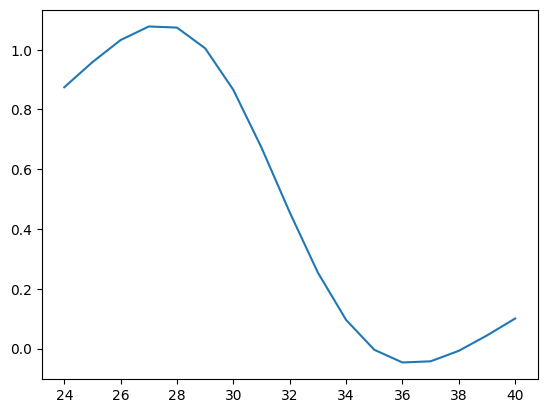

In [8]:
center_z = 32
crop_z_span = 8

z_target = z_target[center_z - crop_z_span:center_z + crop_z_span + 1]
volume_mean_per_z_target = volume_mean_per_z_target[center_z - crop_z_span:center_z + crop_z_span + 1]

plt.plot(z_target, volume_mean_per_z_target, label='target')

In [9]:
for i, path in enumerate(fragment_pathes):
    name = path.split('/')[-1]
    
    volume = normalize_volume(volumes[i], scroll_masks[i], normalize='minmax')
    z, volume_mean_per_z = get_z_volume_mean_per_z(
        volume, scroll_masks[i]
    )
    z_shift, z_scale = fit_x_shift_scale(z, volume_mean_per_z, z_target, volume_mean_per_z_target)

    print(
        f'name={name}: '
        f'z_shift={z_shift}, '
        f'z_scale={z_scale}'
    )

name=1: z_shift=-2.1566005597432385, z_scale=1.061617161111591
name=2: z_shift=12.251172356113942, z_scale=0.5708897318576389
name=3: z_shift=0.0, z_scale=1.0


In [10]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
for i, path in enumerate(fragment_pathes):
    name = path.split('/')[-1]

    volume = normalize_volume(volumes[i], scroll_masks[i], normalize='minmax')
    z, volume_mean_per_z = get_z_volume_mean_per_z(
        volume, scroll_masks[i]
    )
    z_shift, z_scale = fit_x_shift_scale(z, volume_mean_per_z, z_target, volume_mean_per_z_target)

    z = z * z_scale + z_shift
    ax = axes[0]
    ax.plot(z, volume_mean_per_z, label=f'{name}')

    H, W, D = volumes[i].shape
    scroll_mask_flattened_xy = (scroll_masks[i] > 0).flatten()
    volume_flattened_xy = volume.reshape(H * W, D)
    volume_flattened_xy_scroll = volume_flattened_xy[scroll_mask_flattened_xy].astype(float)

    volume_flattened_xy_scroll = cv2.resize(
        volume_flattened_xy_scroll, 
        (0, 0),
        fx=z_scale, 
        fy=1,
        interpolation=cv2.INTER_LINEAR,
    )

    z_shift_ = round(z_shift)
    if round(z_shift) > 0:
        volume_flattened_xy_scroll = cv2.copyMakeBorder(
            volume_flattened_xy_scroll,
            top=0,
            bottom=0,
            left=z_shift_,
            right=0,
            borderType=cv2.BORDER_CONSTANT, 
            value=0,
        )
    else:
        volume_flattened_xy_scroll = volume_flattened_xy_scroll[:, -round(z_shift):]
    
    if volume_flattened_xy_scroll.shape[1] < D:
        volume_flattened_xy_scroll = cv2.copyMakeBorder(
            volume_flattened_xy_scroll,
            top=0,
            bottom=0,
            left=0,
            right=D - volume_flattened_xy_scroll.shape[1],
            borderType=cv2.BORDER_CONSTANT, 
            value=0,
        )
    else:
        volume_flattened_xy_scroll = volume_flattened_xy_scroll[:, :D]

    z = np.arange(D)
    volume_mean_per_z = volume_flattened_xy_scroll.mean(0)
    ax = axes[1]
    ax.plot(z, volume_mean_per_z, label=f'{name}')
    
    print(
        f'name={name}: '
        f'min={volume_mean_per_z_min}, '
        f'max={volume_mean_per_z_max}, '
        f'z_scale={z_scale}, '
        f'z_shift={z_shift}'
    )

ax.vlines(center_z, 0, 1, color='k', linewidth=0.5, label='center')
ax.hlines(0.5, 0, 65, color='k', linewidth=0.5)

ax.vlines([center_z + crop_z_span, center_z - crop_z_span], 0, 1, color='r', linewidth=0.5, label='crop z')

ax.set_title('scroll mask')
ax.set_xlabel('z')
ax.set_ylabel('mean intensity')
ax.legend()

name=1: min=22000.041270801805, max=31710.525060789045, z_scale=1.061617161111591, z_shift=-2.1566005597432385


: 

: 

### Fine (grid)

Get target Z and mean curve from fragment 2 (as having best validation score so far)

In [4]:
volume, scroll_mask = volumes[2], scroll_masks[2]

subtract, divide = calculate_statistics(volume, scroll_mask, mode='volume_mean_per_z', normalize='minmax')

volume = normalize_volume(volume, scroll_mask, mode='volume_mean_per_z', normalize='minmax', precomputed=(subtract, divide))
z_target, volume_mean_per_z_target = get_z_volume_mean_per_z(volume, scroll_mask)

In [5]:
z_target

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

In [6]:
volume_mean_per_z_target

array([ 5.13208528e-01,  5.16408885e-01,  5.19434831e-01,  5.21984080e-01,
        5.23897714e-01,  5.25018397e-01,  5.25379059e-01,  5.25026003e-01,
        5.23951138e-01,  5.22097850e-01,  5.19750996e-01,  5.17430883e-01,
        5.15448979e-01,  5.14234214e-01,  5.14447837e-01,  5.16901802e-01,
        5.22654541e-01,  5.32695096e-01,  5.47928805e-01,  5.69591645e-01,
        5.99385291e-01,  6.39242319e-01,  6.90646470e-01,  7.53476899e-01,
        8.24894873e-01,  8.98176349e-01,  9.61862669e-01,  1.00000000e+00,
        9.94738465e-01,  9.31891064e-01,  8.08179900e-01,  6.36992343e-01,
        4.45879897e-01,  2.67190902e-01,  1.26850405e-01,  3.78383233e-02,
       -3.99358636e-16,  3.82105731e-03,  3.56873080e-02,  8.23619561e-02,
        1.33404854e-01,  1.82043457e-01,  2.24758615e-01,  2.60212419e-01,
        2.88509731e-01,  3.10495925e-01,  3.27333343e-01,  3.40104985e-01,
        3.49733725e-01,  3.56971222e-01,  3.62402574e-01,  3.66477129e-01,
        3.69507893e-01,  

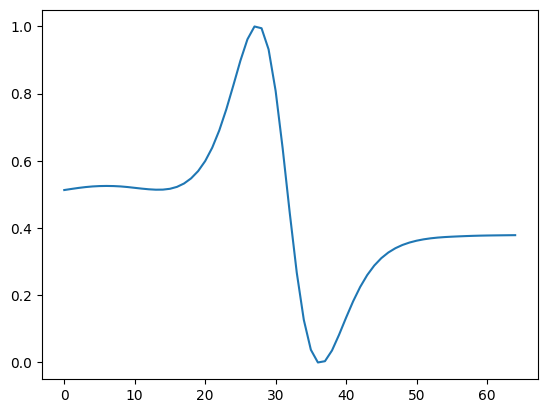

In [7]:
plt.plot(z_target, volume_mean_per_z_target, label='target')

In [8]:
subtract, divide

(22000.041270801805, 9710.48378998724)

In [105]:
# constants of fragment 2
CENTER_Z = 32
Z_TARGET = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])
VOLUME_MEAN_PER_Z_TARGET = np.array([ 5.13208528e-01,  5.16408885e-01,  5.19434831e-01,  5.21984080e-01,
        5.23897714e-01,  5.25018397e-01,  5.25379059e-01,  5.25026003e-01,
        5.23951138e-01,  5.22097850e-01,  5.19750996e-01,  5.17430883e-01,
        5.15448979e-01,  5.14234214e-01,  5.14447837e-01,  5.16901802e-01,
        5.22654541e-01,  5.32695096e-01,  5.47928805e-01,  5.69591645e-01,
        5.99385291e-01,  6.39242319e-01,  6.90646470e-01,  7.53476899e-01,
        8.24894873e-01,  8.98176349e-01,  9.61862669e-01,  1.00000000e+00,
        9.94738465e-01,  9.31891064e-01,  8.08179900e-01,  6.36992343e-01,
        4.45879897e-01,  2.67190902e-01,  1.26850405e-01,  3.78383233e-02,
       -3.99358636e-16,  3.82105731e-03,  3.56873080e-02,  8.23619561e-02,
        1.33404854e-01,  1.82043457e-01,  2.24758615e-01,  2.60212419e-01,
        2.88509731e-01,  3.10495925e-01,  3.27333343e-01,  3.40104985e-01,
        3.49733725e-01,  3.56971222e-01,  3.62402574e-01,  3.66477129e-01,
        3.69507893e-01,  3.71695538e-01,  3.73246001e-01,  3.74380452e-01,
        3.75340047e-01,  3.76180927e-01,  3.76906288e-01,  3.77474479e-01,
        3.77896668e-01,  3.78197379e-01,  3.78455692e-01,  3.78703337e-01,
        3.78895042e-01])
MINMAX_SUBTRACT, MINMAX_DIVIDE = (22060.014794403214, 9586.303729423242)

# params
crop_size_z = 16

assert crop_size_z % 2 == 0
crop_z_span = crop_size_z // 2

z_target = Z_TARGET[CENTER_Z - crop_z_span:CENTER_Z + crop_z_span + 1]
volume_mean_per_z_target = VOLUME_MEAN_PER_Z_TARGET[CENTER_Z - crop_z_span:CENTER_Z + crop_z_span + 1]

In [106]:
z_target.shape, volume_mean_per_z_target.shape

((17,), (17,))

In [107]:
volume_mean_per_z_target

array([ 8.19090915e-01,  8.93921736e-01,  9.59635389e-01,  1.00000000e+00,
        9.96699557e-01,  9.34978160e-01,  8.11236365e-01,  6.39128180e-01,
        4.46826327e-01,  2.67314928e-01,  1.26729596e-01,  3.78190692e-02,
       -3.77020070e-16,  3.48869987e-03,  3.46864534e-02,  8.05473512e-02,
        1.30839698e-01])

In [72]:
subtracts, divides = [], []
for volume, scroll_mask, ink_mask in zip(volumes, scroll_masks, ink_masks):
    subtract, divide = calculate_statistics(
        volume, 
        scroll_mask, 
        ink_mask, 
        mode='volume_mean_per_z', 
        normalize='minmax'
    )
    subtracts.append(subtract)
    divides.append(divide)

12it [00:00, 555.39it/s]
10it [00:00, 451.48it/s]
11it [00:00, 179.63it/s]


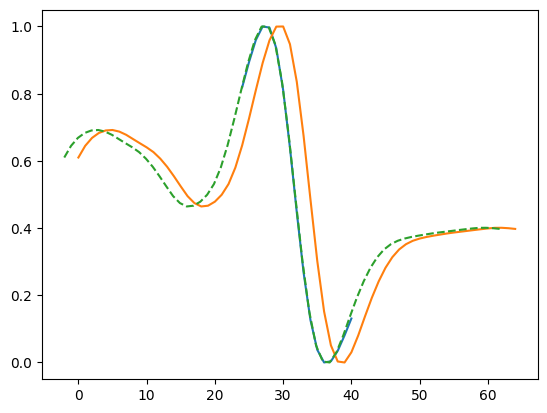

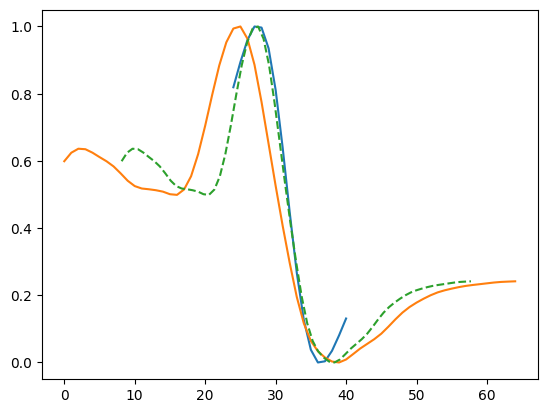

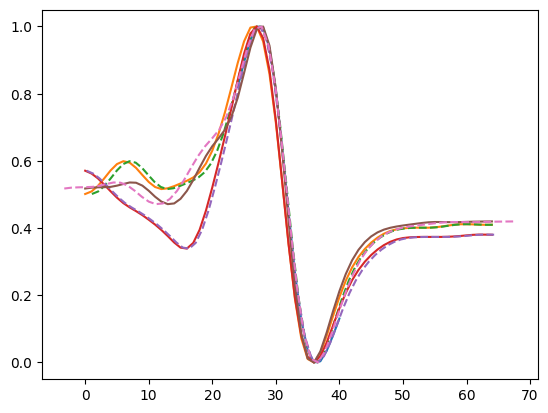

In [109]:
for i, path in enumerate(fragment_pathes):
    dataset = InMemorySurfaceVolumeDataset(
        volumes=[volumes[i]],
        scroll_masks=[scroll_masks[i]],
        pathes=[path],
        ir_images=[ir_images[i]],
        ink_masks=[ink_masks[i]],
        transform=None,
        patch_size=(256, 256),
        subtracts=[subtracts[i]],
        divides=[divides[i]],
    )

    plt.figure()
    plt.plot(z_target, volume_mean_per_z_target, label='target')
    for j, item in tqdm(enumerate(dataset)):
        if not item['masks'][0].all():
            continue

        indices = item['indices']
        volume = normalize_volume(
            item['image'], 
            item['masks'][0], 
            item['masks'][2], 
            normalize='minmax',
            # precomputed=(item['subtract'], item['divide'])
        )
        z, volume_mean_per_z = get_z_volume_mean_per_z(
            volume, item['masks'][0], item['masks'][2]
        )

        plt.plot(z, volume_mean_per_z, label='current')
    
        z_shift, z_scale = fit_x_shift_scale(z, volume_mean_per_z, z_target, volume_mean_per_z_target)
        plt.plot(z * z_scale + z_shift, volume_mean_per_z, '--')

        if j >= 10:
            break

In [110]:
params = defaultdict(dict)
for i, path in enumerate(fragment_pathes):
    dataset = InMemorySurfaceVolumeDataset(
        volumes=[volumes[i]],
        scroll_masks=[scroll_masks[i]],
        pathes=[path],
        ir_images=[ir_images[i]],
        ink_masks=[ink_masks[i]],
        transform=None,
        patch_size=(128, 128),
        subtracts=[subtracts[i]],
        divides=[divides[i]],
    )

    z_shifts, z_scales = None, None
    for item in tqdm(dataset):
        if z_shifts is None:
            shape = item['shape_patches'].tolist()
            z_shifts = np.full(shape, fill_value=np.nan, dtype=np.float32)
            z_scales = np.full(shape, fill_value=np.nan, dtype=np.float32)

        if not item['masks'][0].all():
            continue

        indices = item['indices']
        volume = normalize_volume(
            item['image'], 
            item['masks'][0], 
            item['masks'][2], 
            normalize='minmax',
            precomputed=(item['subtract'], item['divide'])
        )
        z, volume_mean_per_z = get_z_volume_mean_per_z(
            volume, item['masks'][0], item['masks'][2]
        )
    
        z_shift, z_scale = fit_x_shift_scale(z, volume_mean_per_z, z_target, volume_mean_per_z_target)

        z_shifts[indices[1], indices[0]] = z_shift
        z_scales[indices[1], indices[0]] = z_scale

    params[path]['z_shifts'] = z_shifts
    params[path]['z_scales'] = z_scales

100%|██████████| 435/435 [00:01<00:00, 244.55it/s]


name=1: z_shifts min=-4.655585289001465, z_shifts max=6.351271152496338, z_shifts mean=1.345158576965332, z_shifts std=1.6294986009597778
name=1: z_scales min=0.7993214130401611, z_scales max=1.119841456413269, z_scales mean=0.947987973690033, z_scales std=0.04792933911085129
name=2: z_shifts min=-29.995525360107422, z_shifts max=16.320598602294922, z_shifts mean=0.518407940864563, z_shifts std=8.676102638244629
name=2: z_scales min=0.4719575047492981, z_scales max=1.8364297151565552, z_scales mean=0.9362602233886719, z_scales std=0.25783801078796387
name=3: z_shifts min=-1.4723321199417114, z_shifts max=4.977395057678223, z_shifts mean=1.9639133214950562, z_shifts std=1.031888723373413
name=3: z_scales min=0.8375382423400879, z_scales max=1.0494120121002197, z_scales mean=0.9372814297676086, z_scales std=0.034199927002191544


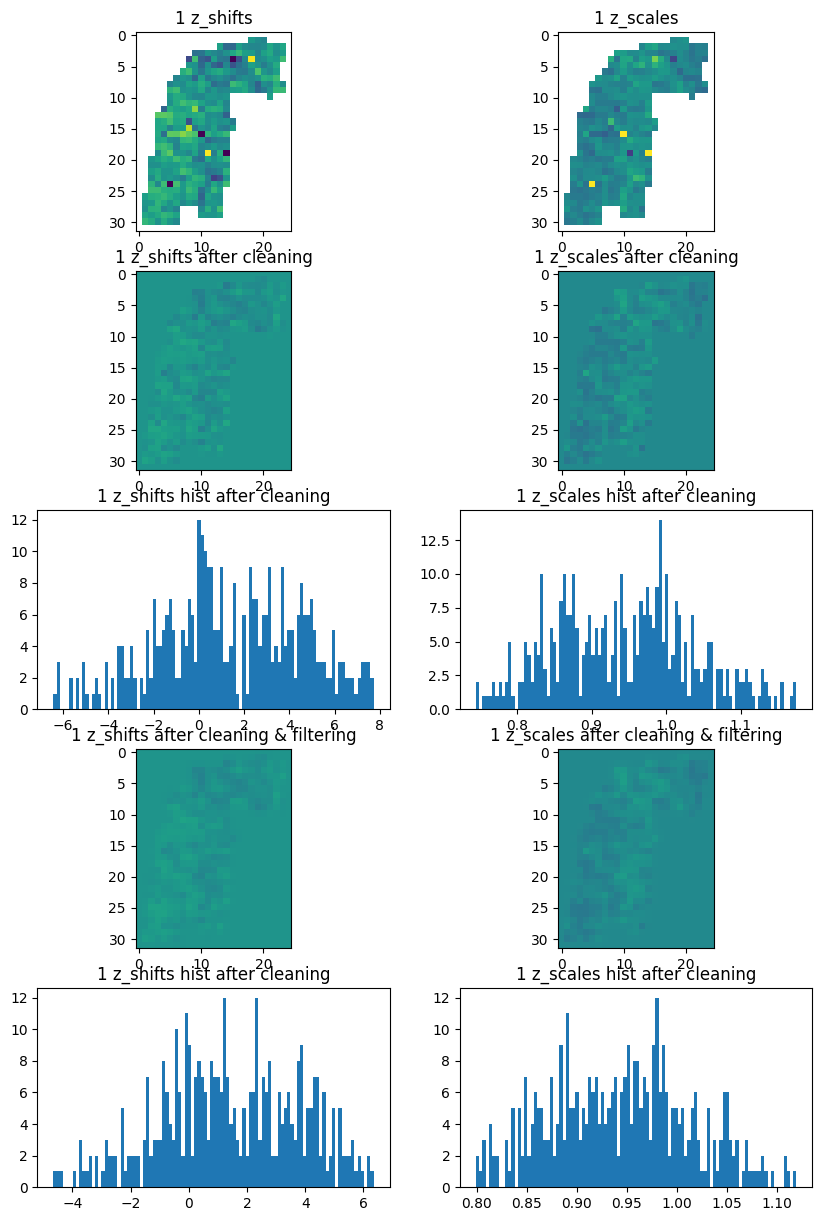

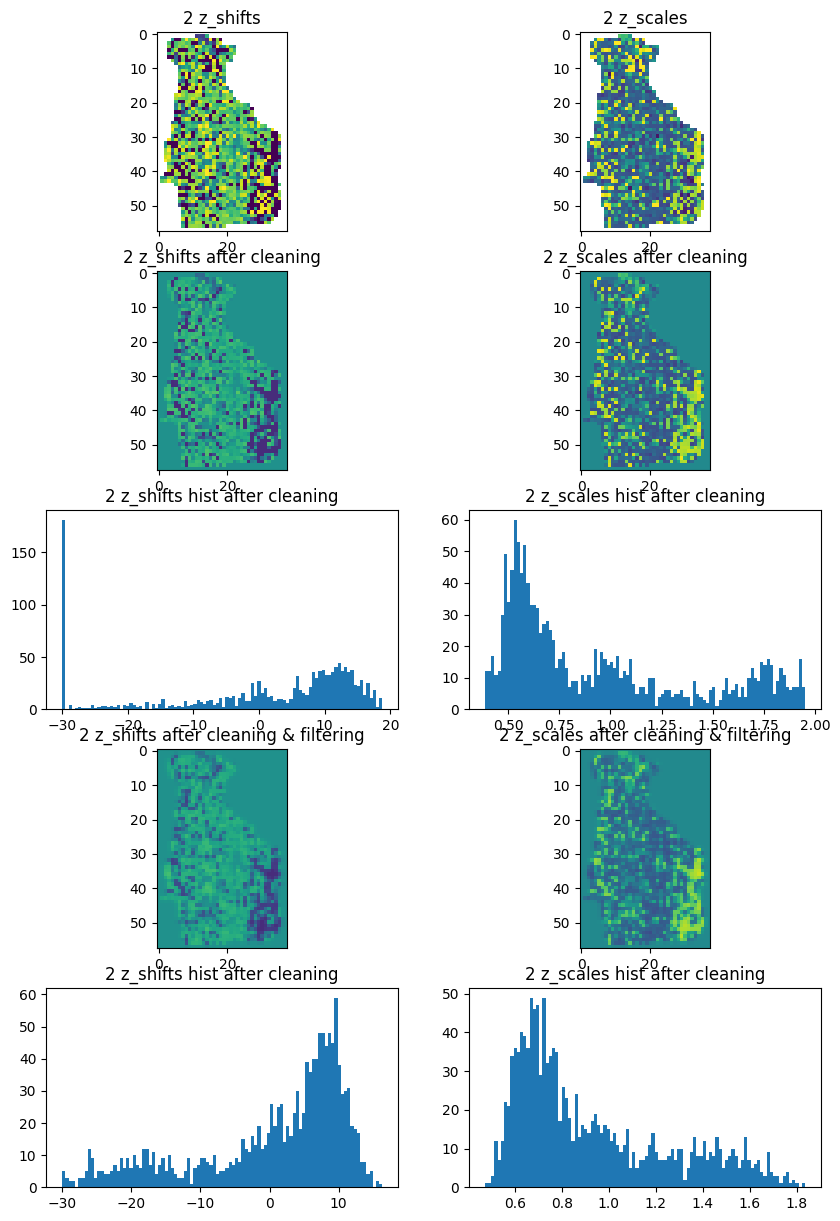

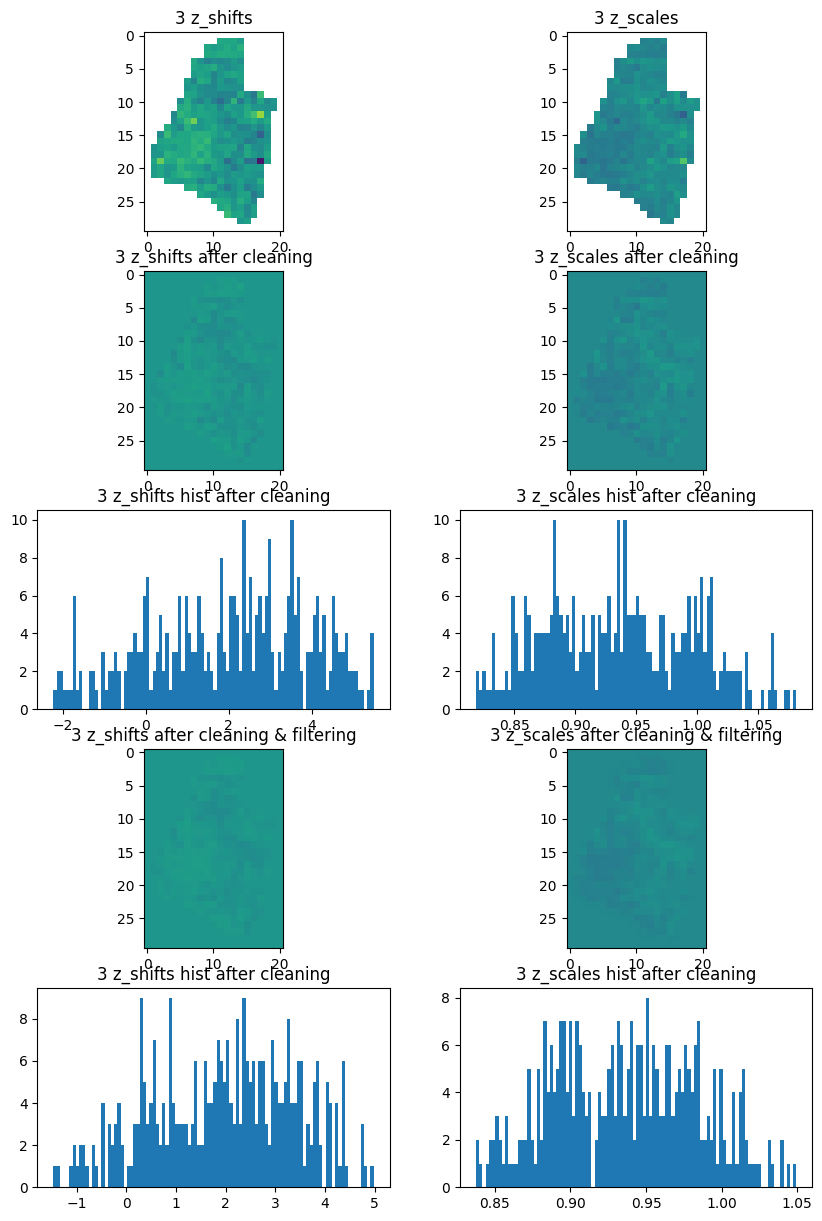

In [111]:
for path, p in params.items():
    name = path.split('/')[-1]
    fig, axes = plt.subplots(5, 2, figsize=(10, 15))

    z_shifts = p['z_shifts'].copy()  # to not modify the original array
    z_scales = p['z_scales'].copy()  # to not modify the original array

    axes[0, 0].imshow(z_shifts, vmin=-20, vmax=20)
    axes[0, 0].set_title(f'{name} z_shifts')
    axes[0, 1].imshow(z_scales, vmin=0, vmax=2)
    axes[0, 1].set_title(f'{name} z_scales')

    z_shifts_nan, z_shifts_outliers = build_nan_or_outliers_mask(z_shifts)
    z_scales_nan, z_scales_outliers = build_nan_or_outliers_mask(z_scales)
    
    z_shifts[z_shifts_nan] = z_shifts[~z_shifts_nan].mean()
    z_scales[z_scales_nan] = z_scales[~z_scales_nan].mean()

    mask = z_shifts_outliers | z_scales_outliers
    z_shifts = interpolate_masked_pixels(z_shifts, mask, method='linear')
    z_scales = interpolate_masked_pixels(z_scales, mask, method='linear')

    axes[1, 0].imshow(z_shifts, vmin=-40, vmax=40)
    axes[1, 0].set_title(f'{name} z_shifts after cleaning')
    axes[1, 1].imshow(z_scales, vmin=0, vmax=2)
    axes[1, 1].set_title(f'{name} z_scales after cleaning')

    axes[2, 0].hist(z_shifts[~z_shifts_nan].flatten(), bins=100)
    axes[2, 0].set_title(f'{name} z_shifts hist after cleaning')
    axes[2, 1].hist(z_scales[~z_scales_nan].flatten(), bins=100)
    axes[2, 1].set_title(f'{name} z_scales hist after cleaning')

    sigma = 0.5
    z_shifts = gaussian_filter(z_shifts, sigma=sigma)
    z_scales = gaussian_filter(z_scales, sigma=sigma)
    axes[3, 0].imshow(z_shifts, vmin=-40, vmax=40)
    axes[3, 0].set_title(f'{name} z_shifts after cleaning & filtering')
    axes[3, 1].imshow(z_scales, vmin=0, vmax=2)
    axes[3, 1].set_title(f'{name} z_scales after cleaning & filtering')
    
    axes[4, 0].hist(z_shifts[~z_shifts_nan].flatten(), bins=100)
    axes[4, 0].set_title(f'{name} z_shifts hist after cleaning')
    axes[4, 1].hist(z_scales[~z_scales_nan].flatten(), bins=100)
    axes[4, 1].set_title(f'{name} z_scales hist after cleaning')

    print(
        f'name={name}: '
        f'z_shifts min={z_shifts.min()}, '
        f'z_shifts max={z_shifts.max()}, '
        f'z_shifts mean={z_shifts.mean()}, '
        f'z_shifts std={z_shifts.std()}'
    ) 
    print( 
        f'name={name}: '
        f'z_scales min={z_scales.min()}, '
        f'z_scales max={z_scales.max()}, '
        f'z_scales mean={z_scales.mean()}, '
        f'z_scales std={z_scales.std()}'
    )

### Transform

In [4]:
subtracts

[18702.340512645755, 16647.617458233388, 22333.030499959255]

In [12]:
i = 0
z_shifts, z_scales = build_z_shift_scale_maps(
    pathes=[fragment_pathes[i]],
    volumes=[volumes[i]],
    scroll_masks=[scroll_masks[i]],
    ir_images=[ir_images[i]],
    ink_masks=[ink_masks[i]],
    subtracts=[subtracts[i]],
    divides=[divides[i]],
)

100%|██████████| 511/511 [00:02<00:00, 199.19it/s]


In [13]:
volumes[0].shape, z_shifts[0].shape, z_scales[0].shape

((4090, 3165, 65), (4090, 3165), (4090, 3165))

In [14]:
z_shifts[0].min(), z_shifts[0].max(), z_shifts[0].mean(), z_shifts[0].std()

(-7.2093167, 7.483117, 0.3718001, 2.0043457)

In [15]:
z_scales[0].min(), z_scales[0].max(), z_scales[0].mean(), z_scales[0].std()

(0.723141, 1.1879119, 0.959813, 0.06456345)

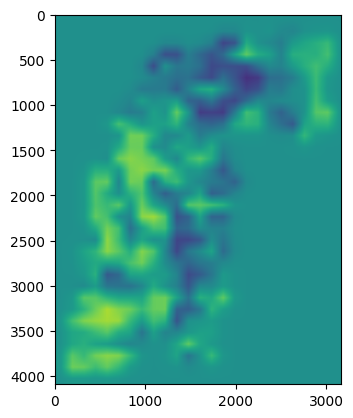

In [16]:
plt.imshow(z_shifts[0], vmin=-10, vmax=10)

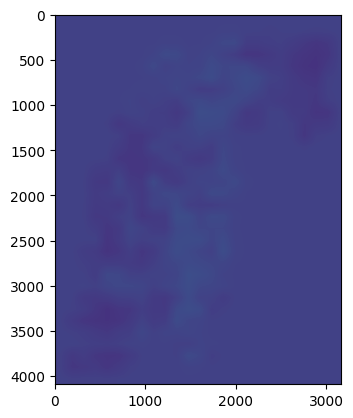

In [10]:
plt.imshow(z_scales[0], vmin=0, vmax=5)

In [120]:
volume = volumes[0][:100, :100]
z_shifts, z_scales = z_shifts[0][:100, :100], z_scales[0][:100, :100]

In [122]:
volume_transformed = geometric_transform(
    volume,
    lambda x: (x[0], x[1], x[2] * z_scales[x[0], x[1]] + z_shifts[x[0], x[1]]),
    order=1,
)

In [124]:
volume_transformed.shape

(100, 100, 65)